In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import seaborn as sns
from matplotlib import pyplot as plt

In [18]:
# Load datasets
df_true = pd.read_csv("./data/NEWS/True.csv")
df_fake = pd.read_csv("./data/NEWS/Fake.csv")

In [19]:
df_true["label"] = 1
df_fake["label"] = 0
df = pd.concat([df_fake, df_true])
df = df.sample(frac=1).reset_index(drop=True)

In [22]:
df.text = df.title+df.text
df.drop(columns=["title", "subject", "date"], axis = 1, inplace=True)

In [23]:
X = df["text"]
Y = df["label"]
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=7)

### Get word embeddings using BERT model

In [24]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [25]:
bert_preprocess_model = hub.KerasLayer(preprocess_url, name='preprocessing')
bert_encoder_model = hub.KerasLayer(encoder_url, name='BERT_encoder')

In [26]:
def getSentenceEmbddings(dataframe_series):
    '''Generate sentence embeddings for a given pandas series of text data using BERT model.'''''
    preprocessed_text = bert_preprocess_model(dataframe_series)
    return bert_encoder_model(preprocessed_text)['pooled_output']

### Define the BERT model

In [27]:
def buildClassifierModel():
    # BERT layers 
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = bert_preprocess_model(text_input)
    outputs = bert_encoder_model(encoder_inputs)

    # Neural network layers
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    
    return tf.keras.Model(text_input, net)

In [28]:
classifier_model = buildClassifierModel()
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [29]:
tf.keras.utils.plot_model(classifier_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Training the BERT model

In [30]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy(name='accuracy')

In [31]:
len(x_train)

35918

In [32]:
epochs =5
steps_per_epoch = len(x_train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [33]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [34]:
classifier_model.fit(x_train, y_train, epochs)

5516/7184 [======================>.......] - ETA: 49:12 - loss: 0.0000e+00 - accuracy: 1.0000

In [23]:
classifier_model.evaluate(x_test, y_test)

37/37 [==============================] - 240s 6s/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

In [24]:
y_predicted = classifier_model.predict(x_test)
y_predicted = y_predicted.flatten()

37/37 [==============================] - 254s 7s/step


In [27]:
y_predicted

array([2.5433204, 2.0633829, 2.5156095, ..., 1.6401168, 1.7677836,
       2.1481462], dtype=float32)

In [36]:
label_dict

{'mixture': 0, 'true': 1, 'false': 2, 'unproven': 3}

In [55]:
def assignCategories(labels):
    for index, value in enumerate(labels):
        if value < 0.5:
            labels[index] = 0
        elif value <1.5:
            labels[index] = 1
        elif value < 2.5: 
            labels[index] = 2
        else:
            labels[index] = 3
    
    return labels


In [56]:
y_predicted = assignCategories(y_predicted).astype(int)

mixture 0
true 1
false 2
unproven 3


In [64]:
y_test = assignCategories(y_test).astype(int)

mixture 0
true 1
false 2
unproven 3


In [58]:
y_plot = np.zeros_like(y_predicted) + 1

In [65]:
cm = confusion_matrix(y_test, y_predicted)
cm 


array([[  2,   6, 150,  33],
       [  0,  25, 464,  79],
       [  6,  11, 286,  67],
       [  0,   2,  34,   8]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

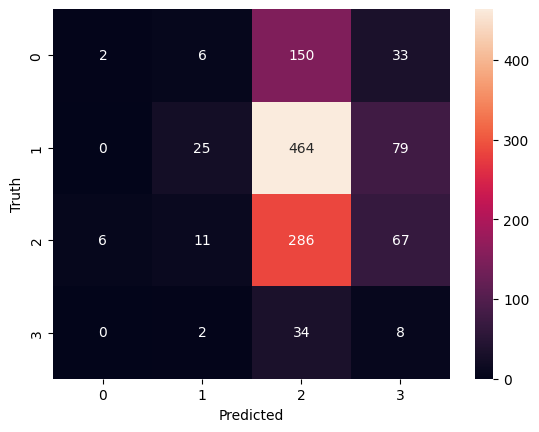

In [66]:
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [67]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.25      0.01      0.02       191
           1       0.57      0.04      0.08       568
           2       0.31      0.77      0.44       370
           3       0.04      0.18      0.07        44

    accuracy                           0.27      1173
   macro avg       0.29      0.25      0.15      1173
weighted avg       0.41      0.27      0.18      1173



#### Save the model

In [70]:
classifier_model.save("bert_classifier.h5", include_optimizer=False)